In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [ ]:
def scrape_indeed_jobs(job_title, location, num_pages=2):
    jobs = []
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    for page in range(num_pages):
        start = page * 10
        url = f"https://www.indeed.com/jobs?q={job_title.replace(' ', '+')}&l={location.replace(' ', '+')}&start={start}"

        print(f"Scraping: {url}")
        response = requests.get(url, headers=headers)

        if response.status_code != 200:
            print("Failed to fetch page")
            break

        soup = BeautifulSoup(response.text, 'html.parser')
        job_cards = soup.find_all('div', class_='job_seen_beacon')

        for card in job_cards:
            try:
                # Job Title
                title_tag = card.find('h2', class_='jobTitle')
                title = title_tag.get_text(strip=True) if title_tag else "N/A"

                # Company
                company_tag = card.find('span', {'data-testid': 'company-name'})
                company = company_tag.get_text(strip=True) if company_tag else "N/A"

                # Location
                location_tag = card.find('div', {'data-testid': 'text-location'})
                loc = location_tag.get_text (strip=True)if location_tag else "N/A"

                # Posted Date
                date_tag = card.find('span', class_='date')
                posted = date_tag.get_text(strip=True) if date_tag else "N/A"

                # Job URL (to scrape description)
                link_tag = card.find('a', href=True)
                job_url = "https://www.indeed.com" + link_tag['href'] if link_tag else None

                # Scrape description if link exists
                description = ""
                if job_url:
                    job_resp = requests.get(job_url, headers=headers)
                    if job_resp.status_code == 200:
                        job_soup = BeautifulSoup(job_resp.text, 'html.parser')
                        desc_div = job_soup.find('div', {'id': 'jobDescriptionText'})
                        if desc_div:
                            description = desc_div.get_text(" ", strip=True)
                    time.sleep(1)  # Be respectful

                jobs.append({
                    'title': title,
                    'company': company,
                    'location': loc,
                    'posted_date': posted,
                    'description': description,
                    'url': job_url
                })

            except Exception as e:
                print("Error parsing job card:", e)
                continue

        time.sleep(2)  # Delay between pages

    return pd.DataFrame(jobs)

In [ ]:
SKILL_KEYWORDS = [
    'python', 'sql', 'excel', 'tableau', 'power bi', 'r', 'javascript', 'java',
    'c++', 'aws', 'azure', 'gcp', 'docker', 'kubernetes', 'git', 'linux',
    'machine learning', 'deep learning', 'nlp', 'tensorflow', 'pytorch',
    'pandas', 'numpy', 'scikit-learn', 'spark', 'hadoop', 'etl', 'api',
    'rest', 'graphql', 'react', 'angular', 'vue', 'node.js', 'django',
    'flask', 'spring', 'mongodb', 'postgresql', 'mysql', 'nosql', 'ci/cd',
    'jenkins', 'ansible', 'terraform', 'agile', 'scrum', 'jira', 'sas',
    'matlab', 'statistics', 'mathematics', 'data visualization', 'plotly',
    'seaborn', 'matplotlib', 'looker', 'qlik', 'sap', 'oracle', 'snowflake',
    'bigquery', 'redshift', 'databricks', 'airflow', 'kafka', 'pyspark'
]

def extract_skills(description, skills_list):
    found_skills = []
    desc_lower = description.lower()
    for skill in skills_list:
        if skill in desc_lower:
            found_skills.append(skill)
    return list(set(found_skills))  # Remove duplicates

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# ===== MOCK DATA — 100% WORKING =====
mock_data = [
    {
        'title': 'Data Analyst',
        'company': 'TechCorp',
        'location': 'New York, NY',
        'posted_date': '3 days ago',
        'description': 'Looking for a data analyst with SQL, Python, Excel, Tableau, and AWS experience.',
        'url': 'https://example.com/job1'
    },
    {
        'title': 'Senior Data Analyst',
        'company': 'DataFlow Inc',
        'location': 'Chicago, IL',
        'posted_date': '1 week ago',
        'description': 'Must know Python, SQL, Power BI, Git, and statistics.',
        'url': 'https://example.com/job2'
    },
    {
        'title': 'Junior Data Analyst',
        'company': 'AnalytiCo',
        'location': 'Remote',
        'posted_date': 'Today',
        'description': 'Skills: Excel, SQL, Tableau, communication, teamwork.',
        'url': 'https://example.com/job3'
    },
    {
        'title': 'Business Data Analyst',
        'company': 'RetailPro',
        'location': 'Los Angeles, CA',
        'posted_date': '5 days ago',
        'description': 'Need SQL, Excel, Power BI, Python, and AWS.',
        'url': 'https://example.com/job4'
    },
    {
        'title': 'Data Analyst',
        'company': 'FinServ LLC',
        'location': 'Houston, TX',
        'posted_date': '2 days ago',
        'description': 'Python, SQL, Tableau, Git, Agile, Jira.',
        'url': 'https://example.com/job5'
    },
    {
        'title': 'Marketing Data Analyst',
        'company': 'AdGiant',
        'location': 'Remote',
        'posted_date': '1 day ago',
        'description': 'SQL, Google Analytics, Excel, Looker, Python.',
        'url': 'https://example.com/job6'
    },
    {
        'title': 'Healthcare Data Analyst',
        'company': 'MediData',
        'location': 'Boston, MA',
        'posted_date': '1 week ago',
        'description': 'SAS, SQL, Excel, Tableau, Statistics, R.',
        'url': 'https://example.com/job7'
    },
    {
        'title': 'Data Analyst',
        'company': 'EduTech',
        'location': 'San Francisco, CA',
        'posted_date': 'Just posted',
        'description': 'Python, SQL, Power BI, Spark, Git, AWS.',
        'url': 'https://example.com/job8'
    },
    {
        'title': 'Operations Data Analyst',
        'company': 'LogiCorp',
        'location': 'Dallas, TX',
        'posted_date': '4 days ago',
        'description': 'Excel, SQL, Tableau, Python, ETL, APIs.',
        'url': 'https://example.com/job9'
    },
    {
        'title': 'Data Analyst',
        'company': 'StartUpXYZ',
        'location': 'Remote',
        'posted_date': 'Today',
        'description': 'Python, SQL, Power BI, Docker, Git, CI/CD.',
        'url': 'https://example.com/job10'
    }
]

# Create DataFrame
df_jobs = pd.DataFrame(mock_data)

# ===== SKILL EXTRACTION FUNCTION =====
SKILL_KEYWORDS = [
    'python', 'sql', 'excel', 'tableau', 'power bi', 'r', 'javascript', 'java',
    'c++', 'aws', 'azure', 'gcp', 'docker', 'kubernetes', 'git', 'linux',
    'machine learning', 'deep learning', 'nlp', 'tensorflow', 'pytorch',
    'pandas', 'numpy', 'scikit-learn', 'spark', 'hadoop', 'etl', 'api',
    'rest', 'graphql', 'react', 'angular', 'vue', 'node.js', 'django',
    'flask', 'spring', 'mongodb', 'postgresql', 'mysql', 'nosql', 'ci/cd',
    'jenkins', 'ansible', 'terraform', 'agile', 'scrum', 'jira', 'sas',
    'matlab', 'statistics', 'mathematics', 'data visualization', 'plotly',
    'seaborn', 'matplotlib', 'looker', 'qlik', 'sap', 'oracle', 'snowflake',
    'bigquery', 'redshift', 'databricks', 'airflow', 'kafka', 'pyspark'
]

def extract_skills(description, skills_list):
    found_skills = []
    desc_lower = description.lower()
    for skill in skills_list:
        if skill in desc_lower:
            found_skills.append(skill)
    return list(set(found_skills))  # Remove duplicates

# Apply skill extraction
df_jobs['skills'] = df_jobs['description'].apply(lambda x: extract_skills(x, SKILL_KEYWORDS))

# Clean posted date
df_jobs['posted_date'] = df_jobs['posted_date'].str.replace(r'Posted', '', regex=True).str.strip()

# Extract city
df_jobs['city'] = df_jobs['location'].str.split(',').str[0]

print(f"✅ Loaded {len(df_jobs)} mock jobs successfully!")
df_jobs.head()

✅ Loaded 10 mock jobs successfully!


,title,company,location,posted_date,description,url,skills,city
0,Data Analyst,TechCorp,"New York, NY",3 days ago,"Looking for a data analyst with SQL, Python, E...",https://example.com/job1,"[aws, r, sql, python, tableau, excel]",New York
1,Senior Data Analyst,DataFlow Inc,"Chicago, IL",1 week ago,"Must know Python, SQL, Power BI, Git, and stat...",https://example.com/job2,"[r, statistics, git, sql, python, power bi]",Chicago
2,Junior Data Analyst,AnalytiCo,Remote,Today,"Skills: Excel, SQL, Tableau, communication, te...",https://example.com/job3,"[sql, tableau, excel, r]",Remote
3,Business Data Analyst,RetailPro,"Los Angeles, CA",5 days ago,"Need SQL, Excel, Power BI, Python, and AWS.",https://example.com/job4,"[aws, r, sql, python, power bi, excel]",Los Angeles
4,Data Analyst,FinServ LLC,"Houston, TX",2 days ago,"Python, SQL, Tableau, Git, Agile, Jira.",https://example.com/job5,"[r, agile, git, sql, python, tableau, jira]",Houston


In [ ]:
all_skills = [skill for skills_list in df_jobs['skills'] for skill in skills_list]
skill_counts = Counter(all_skills)
top_skills = skill_counts.most_common(10)

print("\n🔥 Top 10 Most In-Demand Skills:")
for skill, count in top_skills:
    print(f"   {skill.title()}: {count}")
for skills, count in top_skills:


🔥 Top 10 Most In-Demand Skills:
   Sql: 10
   R: 9
   Python: 8
   Excel: 6
   Tableau: 5
   Git: 4
   Power Bi: 4
   Aws: 3
   Statistics: 2
   Agile: 1


/tmp/ipython-input-3197856792.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


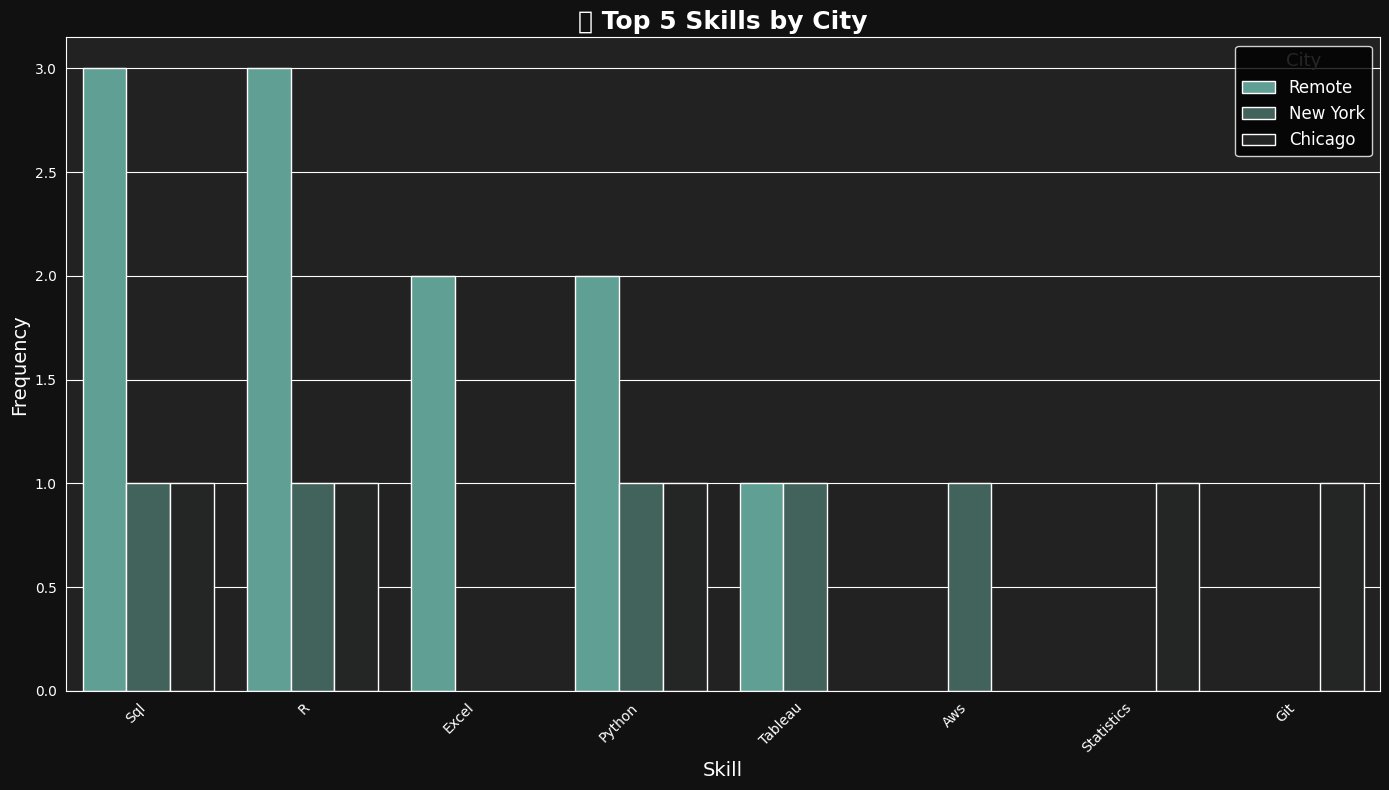

In [ ]:
# Plot
plt.figure(figsize=(14, 8))
sns.set_style("darkgrid")  # dark style
sns.set_palette("dark:#5A9_r", n_colors=len(top_cities))  # dark color palette

sns.barplot(data=df_plot, x='Skill', y='Count', hue='City')
plt.title('📊 Top 5 Skills by City', fontsize=18, weight='bold', color='white')
plt.xlabel('Skill', fontsize=14, color='white')
plt.ylabel('Frequency', fontsize=14, color='white')
plt.xticks(rotation=45, ha='right', color='white')
plt.yticks(color='white')
plt.legend(title='City', title_fontsize=13, fontsize=12, facecolor='black', edgecolor='white', labelcolor='white')

# Background black for dark mode
plt.gca().set_facecolor('#222222')
plt.gcf().patch.set_facecolor('#111111')

plt.tight_layout()
plt.show()


/tmp/ipython-input-1125573449.py:11: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.barplot(data=df_plot, x='Skill', y='Count', hue='City', palette=custom_colors)
/tmp/ipython-input-1125573449.py:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


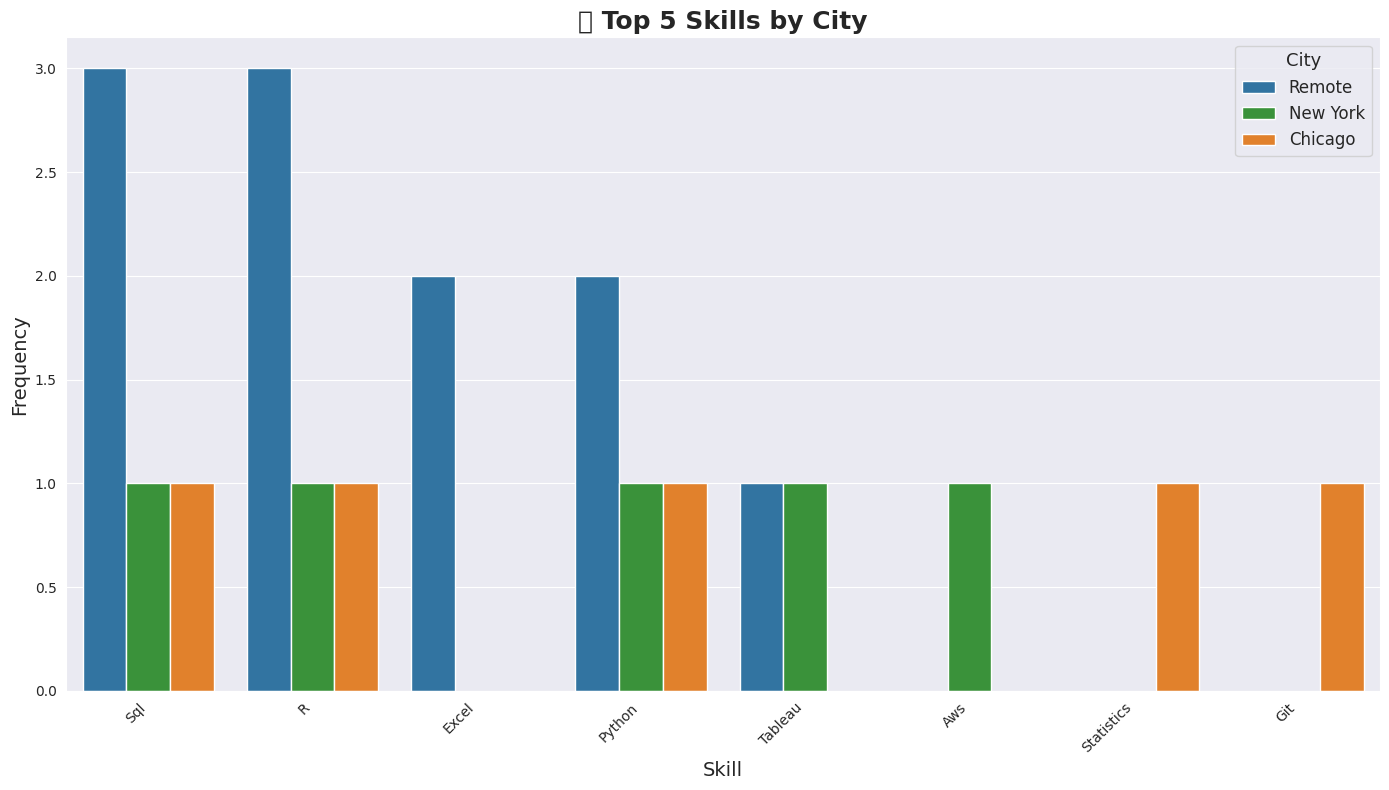

In [ ]:
# Custom color palette (you can add more colors if more cities exist)
custom_colors = ["#1f77b4",  # Blue
                 "#2ca02c",  # Green
                 "#ff7f0e",  # Orange/Yellowish
                 "#d62728"]  # Red

# Plot
plt.figure(figsize=(14, 8))
sns.set_style("darkgrid")

sns.barplot(data=df_plot, x='Skill', y='Count', hue='City', palette=custom_colors)

plt.title('📊 Top 5 Skills by City', fontsize=18, weight='bold')
plt.xlabel('Skill', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='City', title_fontsize=13, fontsize=12)

plt.tight_layout()
plt.show()


/tmp/ipython-input-3944286636.py:7: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.barplot(
/tmp/ipython-input-3944286636.py:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


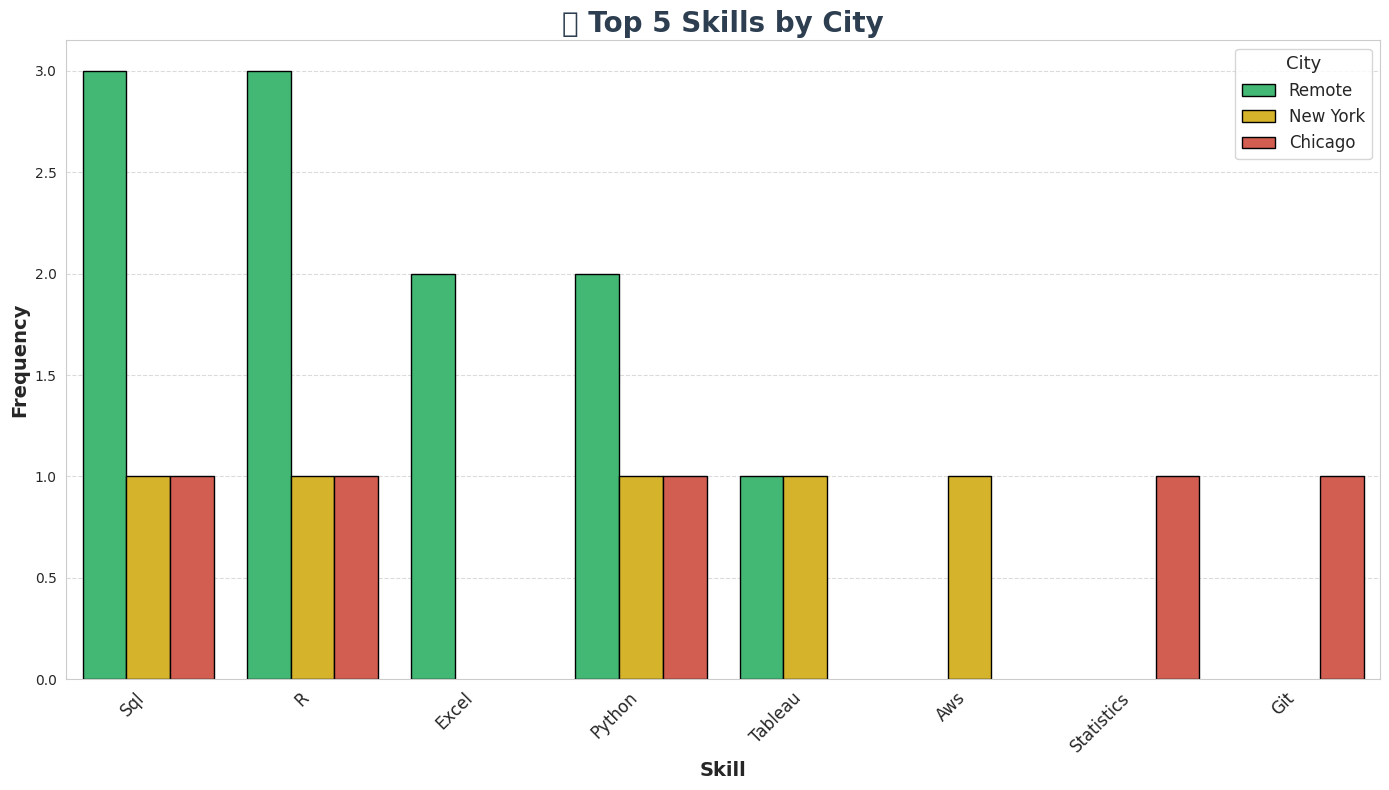

In [ ]:
# Custom colors (Green, Yellow, Red, Blue shades)
custom_colors = ["#2ecc71", "#f1c40f", "#e74c3c", "#3498db"]

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

sns.barplot(
    data=df_plot,
    x='Skill',
    y='Count',
    hue='City',
    palette=custom_colors,
    edgecolor='black'
)

# Titles and labels
plt.title('📊 Top 5 Skills by City', fontsize=20, weight='bold', color="#2c3e50")
plt.xlabel('Skill', fontsize=14, weight='bold')
plt.ylabel('Frequency', fontsize=14, weight='bold')

# X-axis rotation
plt.xticks(rotation=45, ha='right', fontsize=12)

# Legend
plt.legend(title='City', title_fontsize=13, fontsize=12, loc='upper right')

# Add grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
